In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [14]:
'''train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')'''

"train_a = pd.read_parquet('A/train_targets.parquet')\ntrain_b = pd.read_parquet('B/train_targets.parquet')\ntrain_c = pd.read_parquet('C/train_targets.parquet')\n\nX_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')\nX_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')\nX_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')\n\nX_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')\nX_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')\nX_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')\n\nX_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')\nX_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')\nX_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')"

In [15]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    
    return merged_data, test_resampled

In [16]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx'],
                    html=False,
                    #silent=True,  # It's important to set silent=True to avoid PyCaret's interactive input requests
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')

    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

In [17]:
'''locations = ['A', 'B', 'C']
all_models = []

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = train['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]

    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)

    # Store the model in all_models list
    all_models.append(final_model)'''

"locations = ['A', 'B', 'C']\nall_models = []\n\nfor loc in locations:\n    # Load your data\n    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)\n    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')\n    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')\n    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')\n\n    # Preprocess data\n    X_train, X_test = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)\n    y_train = train['pv_measurement'].values\n\n    # Ensure X and y have the same length\n    min_length = min(len(X_train), len(y_train))\n    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]\n\n    # Process the location data and get the final model\n    final_model = process_location(X_train, y_train, loc)\n\n    # Store the model in all_models list\n    all_models.append(final_model)"

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (34061, 46)
4        Transformed data shape  (34061, 62)
5   Transformed train set shape  (23842, 62)
6    Transformed test set shape  (10219, 62)
7              Numeric features           42
8          Categorical features            3
9      Rows with missing values        97.4%
10                   Preprocess         True
11              Imputation type       simple
12           Numeric imputation         mean
13       Categorical imputation         mode
14     Maximum one-hot encoding           25
15              Encoding method         None
16               Fold Generator        KFold
17                  Fold Number           10
18                     CPU Jobs           -1
19                      Use GPU        False
20               Log Experiment        False
21        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     202.0913  182170.5580  426.8144  0.8672  1.2504  1.3275
1     192.8785  175765.0472  419.2434  0.8669  1.2242  1.2884
2     188.3806  163246.3219  404.0375  0.8769  1.2707  1.5085
3     187.7374  162585.8416  403.2193  0.8873  1.2525  1.4801
4     199.6796  193202.7568  439.5484  0.8585  1.3544  1.8367
5     203.2024  210479.8879  458.7809  0.8444  1.3148  1.5133
6     197.9293  201171.7252  448.5217  0.8550  1.3122  1.7340
7     192.8957  169295.8879  411.4558  0.8771  1.1906  1.2148
8     199.7484  180669.0362  425.0518  0.8698  1.2225  1.2588
9     199.9936  210477.7095  458.7785  0.8466  1.3494  1.2449
Mean  196.4537  184906.4772  429.5452  0.8650  1.2742  1.4407
Std     5.2904   17208.5569   19.9353  0.0131  0.0533  0.2032


Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     203.0405  186466.8836  431.8181  0.8641  1.3173  1.7052
1     195.4510  178940.7393  423.0139  0.8645  1.3483  1.2889
2     188.6688  168772.1163  410.8188  0.8727  1.3262  1.8837
3     184.3176  154213.0842  392.6997  0.8931  1.2919  1.9547
4     197.7693  192621.7028  438.8869  0.8589  1.3804  2.1457
5     200.4196  201603.8951  449.0032  0.8510  1.4109  1.6544
6     190.5849  184500.3472  429.5350  0.8670  1.3475  1.7576
7     198.1652  178601.7667  422.6130  0.8703  1.3573  1.3687
8     203.4899  183101.1893  427.9032  0.8681  1.3139  1.3808
9     201.9291  209483.1905  457.6933  0.8474  1.3560  1.3943
Mean  196.3836  183830.4915  428.3985  0.8657  1.3450  1.6534
Std     6.2173   14880.7463   17.4697  0.0120  0.0329  0.2748


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     195.1564  174477.0732  417.7045  0.8728  1.1515  1.4155
1     188.3839  169237.7587  411.3852  0.8718  1.1444  1.2986
2     182.7060  159372.6791  399.2151  0.8798  1.1581  1.5930
3     180.2907  151721.6784  389.5147  0.8949  1.1050  1.6098
4     197.1874  190977.4951  437.0097  0.8601  1.1971  1.9155
5     196.9291  197680.9799  444.6133  0.8539  1.1321  1.4025
6     190.4793  192495.2093  438.7428  0.8612  1.1660  1.5440
7     191.3781  167797.8828  409.6314  0.8782  1.1477  1.2625
8     195.4021  173091.9578  416.0432  0.8753  1.1457  1.2705
9     198.5396  210487.1216  458.7888  0.8466  1.1746  1.2147
Mean  191.6453  178733.9836  422.2649  0.8695  1.1522  1.4527
Std     5.9457   17523.6424   20.6488  0.0134  0.0234  0.2051
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. C

          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     39.0899  6131.3407  78.3029  0.8386  1.5386  37.2687
1     39.6037  6318.1876  79.4870  0.8254  1.5439   2.5762
2     38.8955  5680.5450  75.3694  0.8594  1.5577   1.4995
3     37.6943  5720.0710  75.6312  0.8388  1.5808   1.9996
4     39.6403  6383.5762  79.8973  0.8307  1.5988   1.9596
5     39.7390  6552.0485  80.9447  0.8339  1.5617   1.5384
6     39.2458  6441.7057  80.2602  0.8479  1.5748   1.3439
7     37.0217  5406.3238  73.5277  0.8418  1.6213   1.7215
8     37.2139  5219.2521  72.2444  0.8598  1.5530   1.9862
9     36.3803  5071.1702  71.2121  0.8717  1.6225   1.9445
Mean  38.4524  5892.4221  76.6877  0.8448  1.5753   5.3838
Std    1.1863   515.2583   3.3793  0.0140  0.0287  10.6334


Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     38.7177  6274.2427  79.2101  0.8348  1.5152  27.8618
1     37.9486  6079.0321  77.9681  0.8320  1.5220   2.0358
2     37.2351  5533.5194  74.3876  0.8631  1.5593   1.3752
3     36.7964  5562.5367  74.5824  0.8432  1.5369   1.7893
4     38.5522  6262.3033  79.1347  0.8340  1.5732   1.7217
5     38.1244  6235.6745  78.9663  0.8420  1.5534   1.3576
6     37.3276  6026.6859  77.6317  0.8577  1.5456   1.3013
7     36.4427  5153.2741  71.7863  0.8492  1.5933   1.5984
8     36.1551  5089.4779  71.3406  0.8633  1.5141   1.7721
9     34.9003  4993.7471  70.6664  0.8736  1.5679   1.7128
Mean  37.2200  5721.0494  75.5674  0.8493  1.5481   4.2526
Std    1.1259   489.4790   3.2576  0.0137  0.0250   7.8728


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     37.6442  6157.6151  78.4705  0.8379  1.4444  27.0761
1     37.9804  6115.4400  78.2013  0.8310  1.4916   2.1396
2     36.9484  5409.2982  73.5479  0.8661  1.4892   1.4095
3     35.9437  5521.5693  74.3073  0.8444  1.4808   1.7252
4     37.6763  6090.8903  78.0442  0.8385  1.5054   1.6443
5     37.9838  6285.0068  79.2780  0.8407  1.4946   1.3679
6     36.8193  5957.8613  77.1872  0.8593  1.4751   1.2570
7     35.1844  4913.0840  70.0934  0.8562  1.5384   1.6464
8     36.1261  4999.9581  70.7104  0.8657  1.4855   1.7056
9     34.3206  4866.7357  69.7620  0.8769  1.5125   1.8229
Mean  36.6627  5631.7459  74.9602  0.8517  1.4917   4.1794
Std    1.1855   530.7454   3.5655  0.0144  0.0234   7.6360
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [W

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     27.3261  4230.6343  65.0433  0.7982  1.5342  0.7099
1     29.0478  4422.8014  66.5041  0.8187  1.5318  0.7637
2     25.3262  3747.4773  61.2166  0.8249  1.5194  0.6951
3     29.4767  4430.9160  66.5651  0.8283  1.6164  0.9098
4     26.6814  4378.9969  66.1740  0.7891  1.5029  0.5308
5     26.0123  3671.4377  60.5924  0.8500  1.5170  0.6182
6     26.9067  3974.3076  63.0421  0.8514  1.4807  0.8333
7     26.5581  3637.2721  60.3098  0.8431  1.4800  0.7171
8     26.3109  3801.1527  61.6535  0.8213  1.5584  0.5724
9     27.4431  3805.3801  61.6878  0.8300  1.5914  0.5980
Mean  27.1089  4010.0376  63.2789  0.8255  1.5332  0.6948
Std    1.2276   306.8620   2.4127  0.0194  0.0423  0.1131


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     28.0452  4421.6607  66.4956  0.7891  1.5590  0.7312
1     30.1267  4795.7248  69.2512  0.8034  1.5860  0.7525
2     25.8598  3718.6694  60.9809  0.8263  1.5541  0.7420
3     29.7757  4548.5274  67.4428  0.8237  1.6205  0.8274
4     26.8262  4238.9894  65.1075  0.7958  1.5286  0.5742
5     26.8120  3954.3057  62.8833  0.8384  1.5546  0.6245
6     28.8911  4452.2505  66.7252  0.8336  1.5398  1.0370
7     27.6245  3870.1874  62.2108  0.8330  1.5299  0.7392
8     25.7338  3593.3642  59.9447  0.8311  1.5888  0.5805
9     28.1139  3961.4919  62.9404  0.8230  1.6424  0.6000
Mean  27.7809  4155.5172  64.3982  0.8197  1.5704  0.7208
Std    1.4371   373.7072   2.8958  0.0164  0.0364  0.1335


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     27.4967  4190.5185  64.7342  0.8001  1.5312  0.6814
1     29.6590  4658.9944  68.2568  0.8090  1.5281  0.8002
2     25.3582  3777.1749  61.4587  0.8235  1.5017  0.6723
3     29.1094  4241.8816  65.1297  0.8356  1.5868  0.8699
4     26.5496  4307.9608  65.6351  0.7925  1.4819  0.5292
5     25.9970  3585.4396  59.8785  0.8535  1.4985  0.6029
6     26.8863  4065.9819  63.7651  0.8480  1.4561  0.8380
7     26.4450  3552.7576  59.6050  0.8467  1.4637  0.6617
8     26.4095  3756.3227  61.2888  0.8234  1.5552  0.5658
9     27.3951  3862.2217  62.1468  0.8274  1.5728  0.5745
Mean  27.1306  3999.9254  63.1899  0.8260  1.5176  0.6796
Std    1.2777   335.8824   2.6391  0.0196  0.0426  0.1135
Transformation Pipeline and Model Successfully Saved
Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'cle

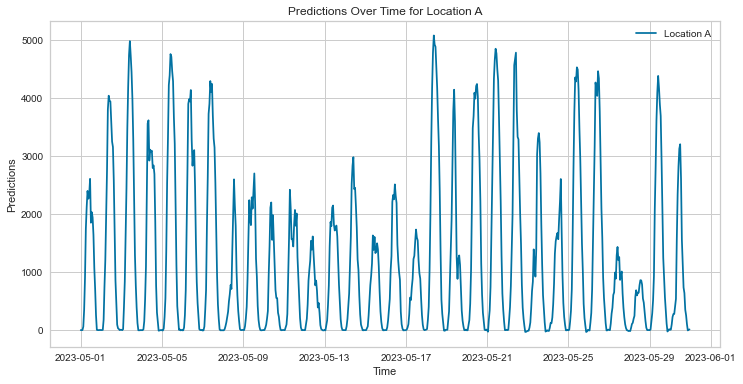

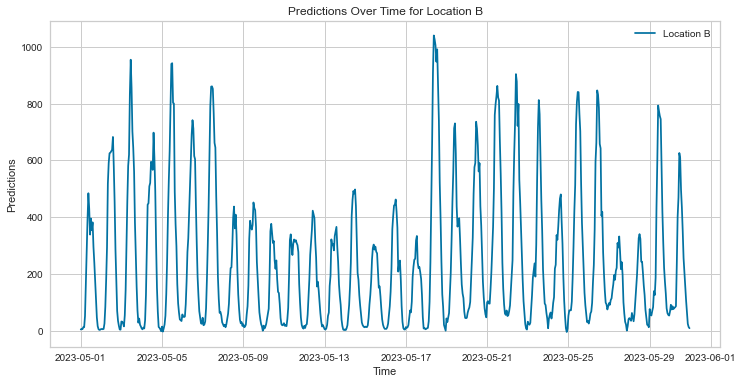

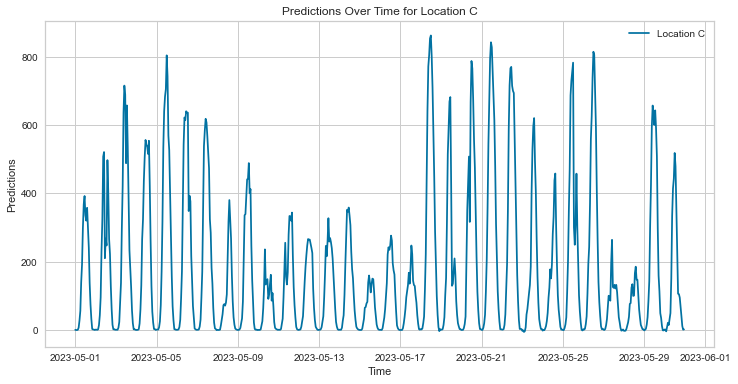

In [18]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 

for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = train['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]

    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)

    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
    print(predictions.columns)

    # Store predictions
    all_predictions.append(predictions['prediction_label'])  

    # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
        'time': timestamps,
        'prediction': predictions['prediction_label'],
        'location': loc
    })

    final_df_list.append(df)

# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    
    # Plotting
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [21]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)